# Analysis of Food Deserts in Washington State and the US by Ngoc Bui #
## Background ##

### Food Deserts ###
A **food desert** is a neighborhood where people have **limited access to affordable and nutritious food**, in contrast with an area with higher access to supermarkets or vegetable shops with fresh foods, which is called a food oasis.

Limited access to supermarkets, supercenters, grocery stores, or other sources of healthy and affordable food may make it harder for people to eat a healthy diet. There are many ways to measure food store access for neighborhoods, and many ways to define which areas are food deserts. Most measures and definitions take into account at least some of the following indicators of access:

- Accessibility to sources of healthy food, as measured by distance to a store or by the number of stores in an area.
- Resources that may affect accessibility, such as family income or vehicle availability.

In this study, we will look into the classification of low income and low access census tracts as indicators of food deserts. A census tract is seen as a food desert when it is classified as both low income and low access.

### Census Tracts ###
A **census tract** is a geographic region defined for the purpose of taking a census. Here, we will focus on census tracts in the USA, more specifically Washington State due to its close geographical distance to BC, Canada.

### Low Income (LI) Status ###
We define low income census tracts as those with: 
- A poverty rate which is 20 percent or greater; or
- A median family income is less than or equal to 80 percent of the State-wide median family income; or
- The tract is in a metropolitan area and has a median family income less than or equal to 80 percent of the metropolitan area's median family income.

We look into low income as an indicator for food deserts since low family income can be a barrier to affording a nuitritious diet.

### Low Access (LA) Status ###
A census tract is considered to have low access if a significant number or share of individuals in the tract is far from a supermarket. Here, a census tract is flagged as low access when a large of number of people (at least 500 people) or share (at least 33 percent) of the population is greater than 1.0 mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 10 miles for a rural area.

We look into low access as an indicator for food deserts since not being near sources of fresh and nuitritious can make people become reliant on over-processed and unhealthy junk food that can be stored for longer.

### Low Income - Low Access (LILA) Status ###
A census tract that is both considered low income and has low access to healthy food supply.

## Why Study Food Deserts? ##
We want to learn if there are certain main characteristics that food deserts share. It is important to learn the demographics of food deserts (age, ethnicity, whether or not the people there are on supplemental benefits such as the SNAP program). With this analysis, we can understand more about which features play an important role in determining the status of a census tract - where it is considered low-income, low-access or both. This analysis can then be used to inform public policy to help eliminate food deserts to ensure that everyone has access to nutritious food.

# Importing Neccessary Packages #

In [110]:
import pandas as pd
import numpy as np
import qeds
qeds.themes.mpl_style();
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.colors as mplc
import matplotlib.patches as patches
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import statsmodels.api as sm
import geopandas as gpd

from sklearn import (
    linear_model, metrics, pipeline, preprocessing, model_selection, feature_selection
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from shapely.geometry import Point, Polygon
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
# activate plot theme


## Data Sources and Cleaning Methods ##

### Data Sources ###
The data is imported from the [USDA Food Access Research Atlas](https://www.ers.usda.gov/data-products/food-access-research-atlas/download-the-data/). This data is taken from the USA and includes detailed information about the census tracts' demographics, income, as well as flags for low income and low access tracts for all states in 2015. The census track shapes are, however, based on the data from 2010. However, as the shape of the census track has not changed much between 2010 and 2015, we can still use the data accordingly.

In [2]:
data = "./DataDownload2015.xlsx"
df_all = pd.read_excel(data, sheet_name = 'Food Access Research Atlas')
df_all

CensusTract    State    County  Urban  POP2010  OHU2010  \
0       1001020100  Alabama   Autauga      1     1912      693   
1       1001020200  Alabama   Autauga      1     2170      743   
2       1001020300  Alabama   Autauga      1     3373     1256   
3       1001020400  Alabama   Autauga      1     4386     1722   
4       1001020500  Alabama   Autauga      1    10766     4082   
...            ...      ...       ...    ...      ...      ...   
72859  56043000200  Wyoming  Washakie      0     3326     1317   
72860  56043000301  Wyoming  Washakie      1     2665     1154   
72861  56043000302  Wyoming  Washakie      1     2542     1021   
72862  56045951100  Wyoming    Weston      0     3314     1322   
72863  56045951300  Wyoming    Weston      1     3894     1699   

       GroupQuartersFlag  NUMGQTRS  PCTGQTRS  LILATracts_1And10  ...  \
0                      0         0  0.000000                  0  ...   
1                      0       181  0.083410                  0  ...   
2                      0         0  0.000000                  0  ...   
3                      0         0  0.000000                  0  ...   
4                      0       181  0.016812                  0  ...   
...                  ...       ...       ...                ...  ...   
72859                  0        57  0.017138                  0  ...   
72860                  0        10  0.003752                  0  ...   
72861                  0        73  0.028717                  0  ...   
72862                  0       252  0.076041                  0  ...   
72863                  0        61  0.015665                  0  ...   

       TractSeniors  TractWhite  TractBlack  TractAsian  TractNHOPI  \
0               221        1622         217          14           0   
1               214         888        1217           5           0   
2               439        2576         647          17           5   
3               904        4086         193          18           4   
4              1126        8666        1437         296           9   
...             ...         ...         ...         ...         ...   
72859           593        3106           6          15           0   
72860           399        2377           5          23           0   
72861           516        2312          11          10           1   
72862           499        3179          15          10           1   
72863           650        3706           6          10           2   

       TractAIAN  TractOMultir  TractHispanic  TractHUNV  TractSNAP  
0             14            45             44         26        112  
1              5            55             75         87        202  
2             11           117             87        108        120  
3             11            74             85         19         82  
4             48           310            355        198        488  
...          ...           ...            ...        ...        ...  
72859         27           172            309         56        116  
72860         40           220            446        114        124  
72861         26           182            407         82         97  
72862         47            62             91        108         50  
72863         44           126            125         95        168  

[72864 rows x 147 columns]

### Data Cleaning Methods ###
First, we filtered out the data related to the census tracts in Washington State.

In [4]:
df_new = df_all[(df_all.State == 'Washington')]

Then, we kept only the neccessary columns:

In [5]:
match = ['CensusTract', 'County', 'Urban', 'POP2010', 'OHU2010', 'MedianFamilyIncome','LILATracts_1And10', 'LowIncomeTracts', 'LA1and10',  'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 
'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP']
sub = df_new[match]
sub

CensusTract  County  Urban  POP2010  OHU2010  MedianFamilyIncome  \
69398  53001950100   Adams      0     2447     1041               58056   
69399  53001950200   Adams      0     1738      699               59653   
69400  53001950300   Adams      1     6934     1801               48906   
69401  53001950400   Adams      1     2856      882               43125   
69402  53001950500   Adams      1     4753     1297               44861   
...            ...     ...    ...      ...      ...                 ...   
70848  53077940002  Yakima      0     4430     1256               52009   
70849  53077940003  Yakima      0     3682     1095               51656   
70850  53077940004  Yakima      1     6777     1664               28237   
70851  53077940005  Yakima      1     4695     1249               30095   
70852  53077940006  Yakima      1     4839     1147               38636   

       LILATracts_1And10  LowIncomeTracts  LA1and10  TractLOWI  ...  \
69398                  0                1         0        840  ...   
69399                  1                1         1        645  ...   
69400                  1                1         1       4127  ...   
69401                  0                1         0       1486  ...   
69402                  0                1         0       2629  ...   
...                  ...              ...       ...        ...  ...   
70848                  0                1         0       2348  ...   
70849                  1                1         1       1850  ...   
70850                  0                1         0       5259  ...   
70851                  0                1         0       3385  ...   
70852                  0                1         0       3203  ...   

       TractSeniors  TractWhite  TractBlack  TractAsian  TractNHOPI  \
69398           516        2326           2          11           0   
69399           305        1524          24          12           2   
69400           477        3747          48          15           2   
69401           330        1764          13          29           0   
69402           287        2342          22          58           0   
...             ...         ...         ...         ...         ...   
70848           473        1459          17          42           7   
70849           431        1164          12          13           3   
70850           440        1106          31         130           7   
70851           364        1750          30          23           0   
70852           277        1400          36          10           7   

       TractAIAN  TractOMultir  TractHispanic  TractHUNV  TractSNAP  
69398         24            84            112         63        192  
69399         10           166            202         13        111  
69400        164          2958           5063         26        496  
69401         50          1000           1973        133        195  
69402        108          2223           3749         22        271  
...          ...           ...            ...        ...        ...  
70848       1503          1402           1911         42        319  
70849       1929           561            681         41        234  
70850       1017          4486           5100        169        716  
70851        489          2403           3595        109        502  
70852        518          2868           4072         78        443  

[1455 rows x 21 columns]

We wanted to add infomation about the demographics of each census tract. To consider the main demographic of a census tract, we take into account the shares of each ethnic group as proportion of the total population for that census tract.

In [6]:
df_all = df_all[match]

df_all['shareBlack'] = (df_all['TractBlack']/df_all['POP2010']).fillna(0) #share of Black population in the census tract
df_all['shareWhite'] = (df_all['TractWhite']/df_all['POP2010']).fillna(0) #share of White population in the census tract
df_all['shareAsian'] = (df_all['TractAsian']/df_all['POP2010']).fillna(0) #share of Asian population in the census tract
df_all['shareNHOPI'] = (df_all['TractNHOPI']/df_all['POP2010']).fillna(0) #share of Native Hawaiian and Other Pacific Islanders population 
                                                                    #in the census tract
df_all['shareHispanic'] = (df_all['TractHispanic']/df_all['POP2010']).fillna(0) #share of Hispanic population in the census tract
df_all['shareAIAN'] = (df_all['TractAIAN']/df_all['POP2010']).fillna(0) #share of American Indian and Alaska Native population in the census tract
df_all['shareMulti'] = (df_all['TractOMultir']/df_all['POP2010']).fillna(0) #share of other/multiracial population in the census tract

df_all['shareKids'] = (df_all['TractKids']/df_all['POP2010']).fillna(0) #share of population 17 years old and under in the census tract
df_all['shareSeniors'] = (df_all['TractSeniors']/df_all['POP2010']).fillna(0) #share of population 65 years old and above in the census tract
df_all['shareSNAP'] = (df_all['TractSNAP']/df_all['POP2010']).fillna(0) #share of population on SNAP benefit in the census tract
df_all['shareLOWI'] = (df_all['TractLOWI']/df_all['POP2010']).fillna(0) #share of low income population in the census tract

df_all['NoVehicleRate'] = (df_all['TractHUNV']/df_all['OHU2010']).fillna(0) #share of household without a vehicle in the census tract


In [7]:
sub['shareBlack'] = (sub['TractBlack']/sub['POP2010']).fillna(0) #share of Black population in the census tract
sub['shareWhite'] = (sub['TractWhite']/sub['POP2010']).fillna(0) #share of White population in the census tract
sub['shareAsian'] = (sub['TractAsian']/sub['POP2010']).fillna(0) #share of Asian population in the census tract
sub['shareNHOPI'] = (sub['TractNHOPI']/sub['POP2010']).fillna(0) #share of Native Hawaiian and Other Pacific Islanders population 
                                                                    #in the census tract
sub['shareHispanic'] = (sub['TractHispanic']/sub['POP2010']).fillna(0) #share of Hispanic population in the census tract
sub['shareAIAN'] = (sub['TractAIAN']/sub['POP2010']).fillna(0) #share of American Indian and Alaska Native population in the census tract
sub['shareMulti'] = (sub['TractOMultir']/sub['POP2010']).fillna(0) #share of other/multiracial population in the census tract

sub['shareKids'] = (sub['TractKids']/sub['POP2010']).fillna(0) #share of population 17 years old and under in the census tract
sub['shareSeniors'] = (sub['TractSeniors']/sub['POP2010']).fillna(0) #share of population 65 years old and above in the census tract
sub['shareSNAP'] = (sub['TractSNAP']/sub['POP2010']).fillna(0) #share of population on SNAP benefit in the census tract
sub['shareLOWI'] = (sub['TractLOWI']/sub['POP2010']).fillna(0) #share of low income population in the census tract

sub['NoVehicleRate'] = (sub['TractHUNV']/sub['OHU2010']).fillna(0) #share of household without a vehicle in the census tract


We then checked to see if there is any null values in the data set. Looks like we are good!

In [8]:
sub.isnull().sum()
df_all.isnull().sum()

CensusTract           0
County                0
Urban                 0
POP2010               0
OHU2010               0
MedianFamilyIncome    0
LILATracts_1And10     0
LowIncomeTracts       0
LA1and10              0
TractLOWI             0
TractKids             0
TractSeniors          0
TractWhite            0
TractBlack            0
TractAsian            0
TractNHOPI            0
TractAIAN             0
TractOMultir          0
TractHispanic         0
TractHUNV             0
TractSNAP             0
shareBlack            0
shareWhite            0
shareAsian            0
shareNHOPI            0
shareHispanic         0
shareAIAN             0
shareMulti            0
shareKids             0
shareSeniors          0
shareSNAP             0
shareLOWI             0
NoVehicleRate         0
dtype: int64

# Data Visualization #
### Loading Shape file and Census tract boundaries ###
To fully visualize the data for our data, we need to load the Census Tract Boundaries from [the US census website](https://www2.census.gov/).

In [9]:
def load_state_df(file):
    df = gpd.read_file(file)
    df = df.rename(columns={'GEOID10': 'CensusTract'})
    df['CensusTract']=df['CensusTract'].astype(int)
    return df
state_df = load_state_df('https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_53_tract10.zip')
dfa = pd.merge(state_df, sub, on="CensusTract")

### Urban and Rural Census Tracts ###
Here, we added the coordinates for the four largest cities in Washington State for us to easily visualize the map of the state.

In [10]:
city = pd.DataFrame({
    'City': ['Seattle', 'Spokane', 'Tacoma', 'Vancouver'],
    'Latitude': [47.6062, 47.6588, 47.2529, 45.6257],
    'Longitude': [-122.3321, -117.4260, -122.4443, -122.6761]
})
city["Coordinates"] = list(zip(city.Longitude, city.Latitude))
city["Coordinates"] = city["Coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(city, geometry="Coordinates")


From the table above, we can see that a family in a urban census tract will on average make more money than a family in a rural census tract. 

Number of urban census (1) and rural census (0) tracts in Washington State is
 1    1122
0     333
Name: Urban, dtype: int64


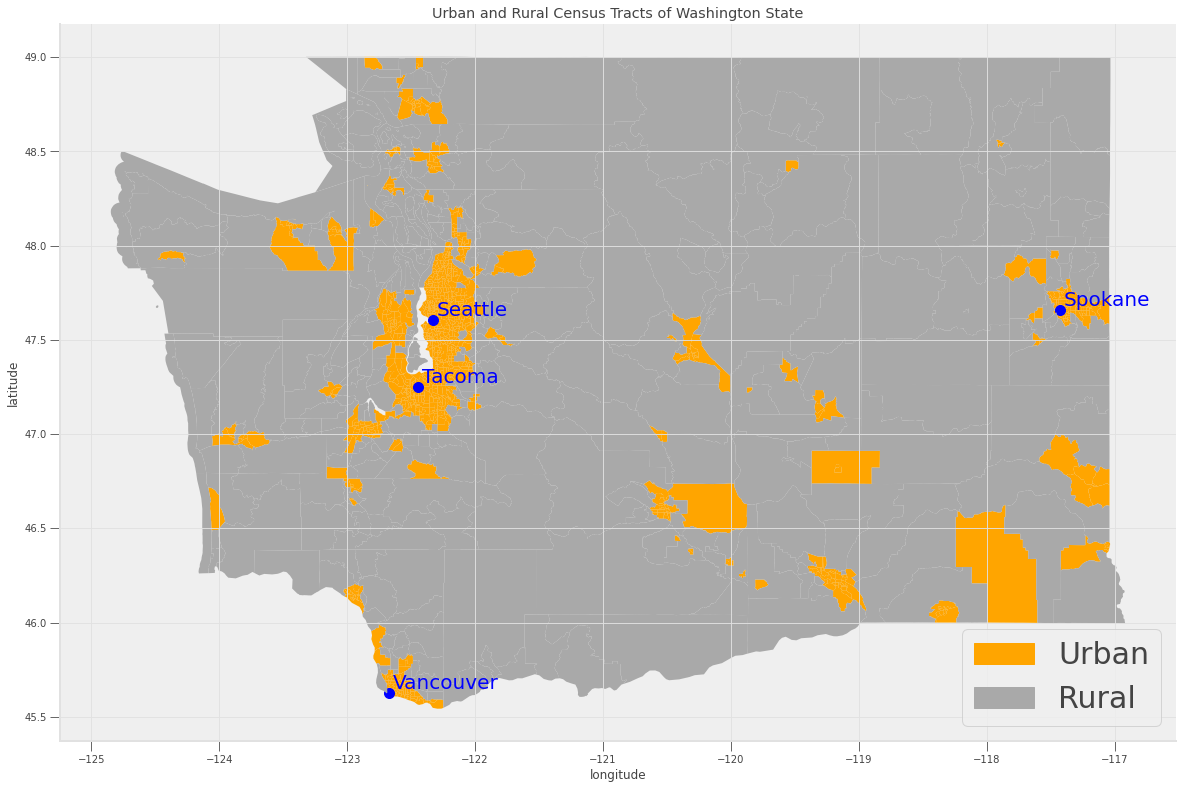

In [11]:
sub_ur = sub['Urban'].value_counts()
print('Number of urban census (1) and rural census (0) tracts in Washington State is\n', sub_ur)

dfa_urban = dfa[(dfa.Urban == 1)]
dfa_rural = dfa[(dfa.Urban == 0)]

fig, ax = plt.subplots(figsize=(20,20))

dfa[dfa.Urban == 1].plot(ax=ax, color='orange')
gdf.plot(ax=ax, color='blue', markersize=100)

dfa[dfa.Urban == 0].plot(ax=ax, color='#a9a9a9')

for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['City']):
    ax.annotate(label, xy=(x,y), xytext=(4,4), color = 'blue', textcoords='offset points',fontsize=20)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('Urban and Rural Census Tracts of Washington State')

LegendElement = [
            patches.Patch(color='orange', label='Urban'),
            patches.Patch(color='#a9a9a9', label='Rural')
                ]
ax.legend(handles = LegendElement, loc='lower right', fontsize = 30)


We can see from the numbers that there are a lot more urban census tracts than rural ones; however, the urban census tracts have a lot less area than the rural ones.

Now, let's look at the average median family income of the urban and rural census tracts:

The mean and median of the median family income of urban (1) and rural (0) census tracts:
      MedianFamilyIncome       
                    mean median
Urban                          
0           68009.933934  66675
1           76415.959893  71509


<AxesSubplot:title={'center':'Average Median Income of Urban and Rural Census Tracts'}, xlabel='Urban'>

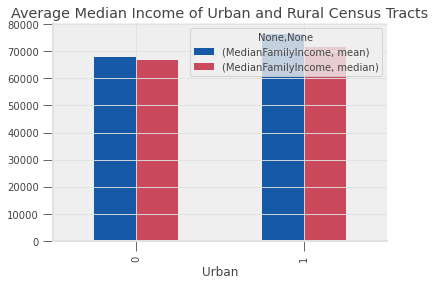

In [16]:
sub_income_urban = sub.groupby(['Urban']).agg({'MedianFamilyIncome': ['mean', 'median']})
print('The mean and median of the median family income of urban (1) and rural (0) census tracts:')
print(sub_income_urban)
sub_income_urban.plot(kind="bar", title = 'Average Median Income of Urban and Rural Census Tracts')

Here, we can see that on average, the median family income of a urban census tract is higher than that of a rural one.

POP2010
           sum
Urban         
0      1369415
1      5355125

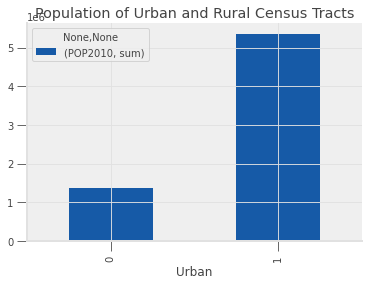

In [15]:
sub_pop_urban = sub.groupby(['Urban']).agg({'POP2010': ['sum']})
sub_pop_urban.plot(kind="bar", title = 'Population of Urban and Rural Census Tracts')
sub_pop_urban

Population of urban census tracts is much higher than that of rural census tracts.

### Low Income Census Tracts ###

Below are the counts of low income vs non low income census tracts. Also, we overlaid the low income census tracts onto the plot of urban and rural census tracts above.

Number of low income (1) census tracts vs non-low-income (0) census tracts in Washington State is
 0    895
1    560
Name: LowIncomeTracts, dtype: int64
Number of low income urban (1) census tracts vs low income rural (0) census tracts in Washington State is
 Urban
1    447
0    113
dtype: int64


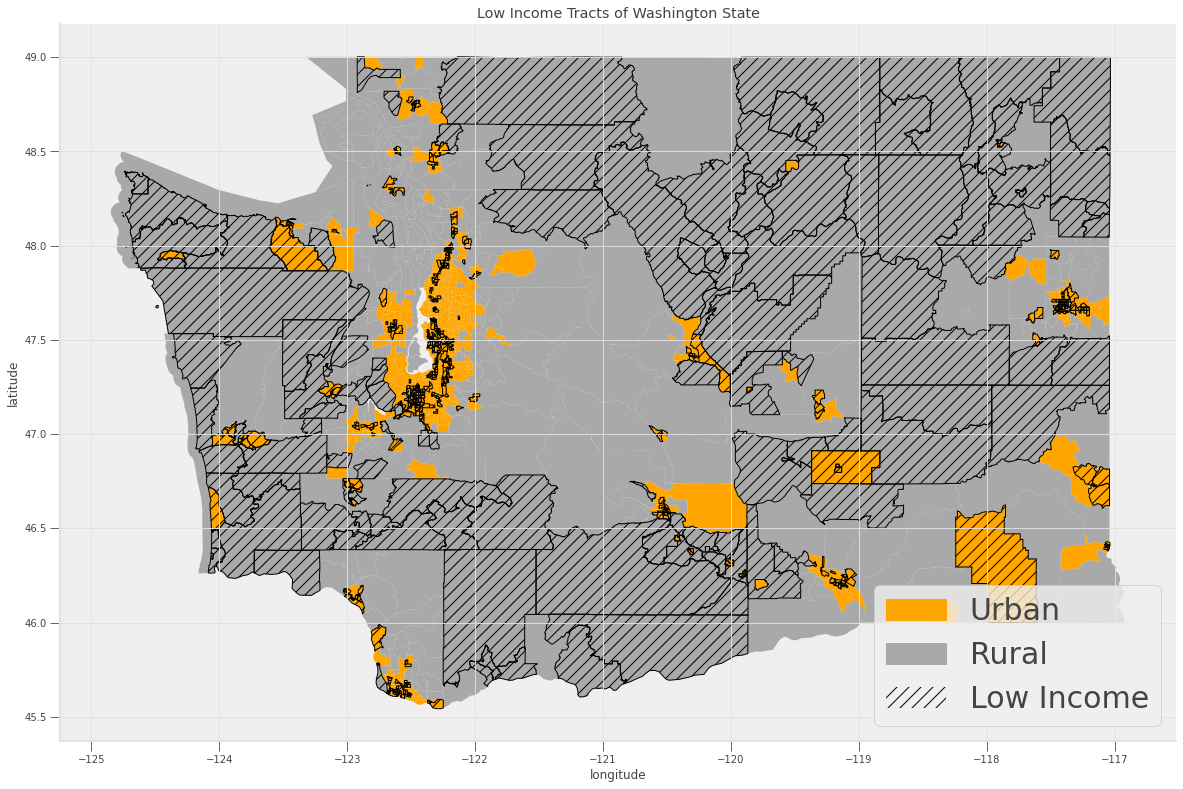

In [17]:
sub_li = sub['LowIncomeTracts'].value_counts()
sub_li_urban = sub[sub.LowIncomeTracts == 1].value_counts('Urban')

print('Number of low income (1) census tracts vs non-low-income (0) census tracts in Washington State is\n', sub_li)
print('Number of low income urban (1) census tracts vs low income rural (0) census tracts in Washington State is\n',sub_li_urban)
fig, ax = plt.subplots(figsize = (20,20))
lowincome = dfa[dfa.LowIncomeTracts == 1]

dfa[dfa.Urban == 1].plot(ax=ax, color='orange')

dfa[dfa.Urban == 0].plot(ax=ax, color='#a9a9a9')

lowincome.plot(ax=ax, facecolor='none', hatch="//", edgecolor= 'k')

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('Low Income Tracts of Washington State')

LegendElement = [
            patches.Patch(color='orange', label='Urban'),
            patches.Patch(color='#a9a9a9', label='Rural'),
            patches.Patch(facecolor='none', hatch="//", label='Low Income')
                ]
ax.legend(handles = LegendElement, loc='lower right', fontsize = 30)

The mean and median of the median family income of urban (1) and rural (0) census tracts:
                MedianFamilyIncome       
                              mean median
LowIncomeTracts                          
0                     89642.756425  84160
1                     50278.121429  51321
The mean and median of the median family income of urban (1) and rural (0) census tracts:
      MedianFamilyIncome       
                    mean median
Urban                          
0           51727.690265  52333
1           49911.675615  50747


<AxesSubplot:title={'center':'Average Median Income of Low Income Urban VS Low Income Rural Tracts'}, xlabel='Urban'>

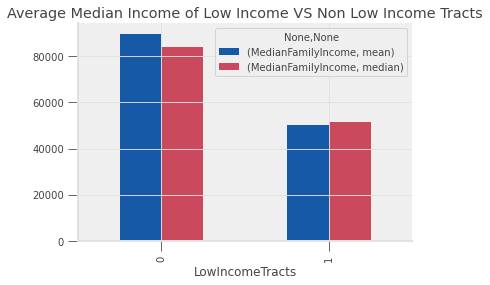

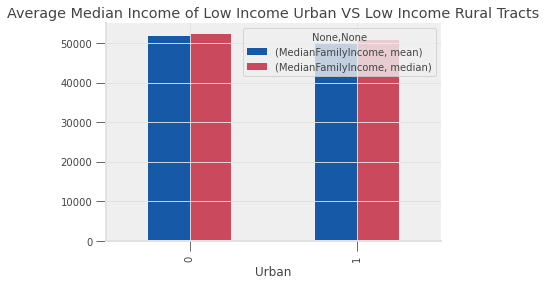

In [18]:
sub_income_li = sub.groupby(['LowIncomeTracts']).agg({'MedianFamilyIncome': ['mean', 'median']})
print('The mean and median of the median family income of urban (1) and rural (0) census tracts:')
print(sub_income_li)
sub_income_li.plot(kind = 'bar', title = 'Average Median Income of Low Income VS Non Low Income Tracts')
sub_li_income_urban = sub[sub.LowIncomeTracts == 1].groupby(['Urban']).agg({'MedianFamilyIncome': ['mean', 'median']})
print('The mean and median of the median family income of urban (1) and rural (0) census tracts:')
print(sub_li_income_urban)
sub_li_income_urban.plot(kind = 'bar', title = 'Average Median Income of Low Income Urban VS Low Income Rural Tracts')


POP2010
                     sum
LowIncomeTracts         
0                4230289
1                2494251

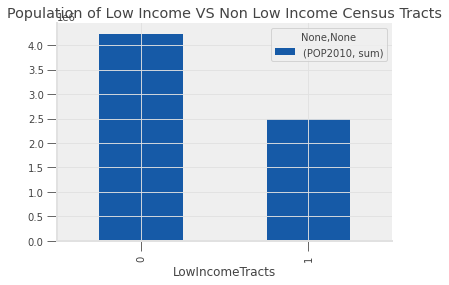

In [19]:
sub_pop_li = sub.groupby(['LowIncomeTracts']).agg({'POP2010': ['sum']})
sub_pop_li.plot(kind="bar", title = 'Population of Low Income VS Non Low Income Census Tracts')
sub_pop_li

### Low Access Census Tracts ###

Number of low access (1) census tracts vs non-low-income (0) census tracts in Washington State is
 0    838
1    617
Name: LA1and10, dtype: int64


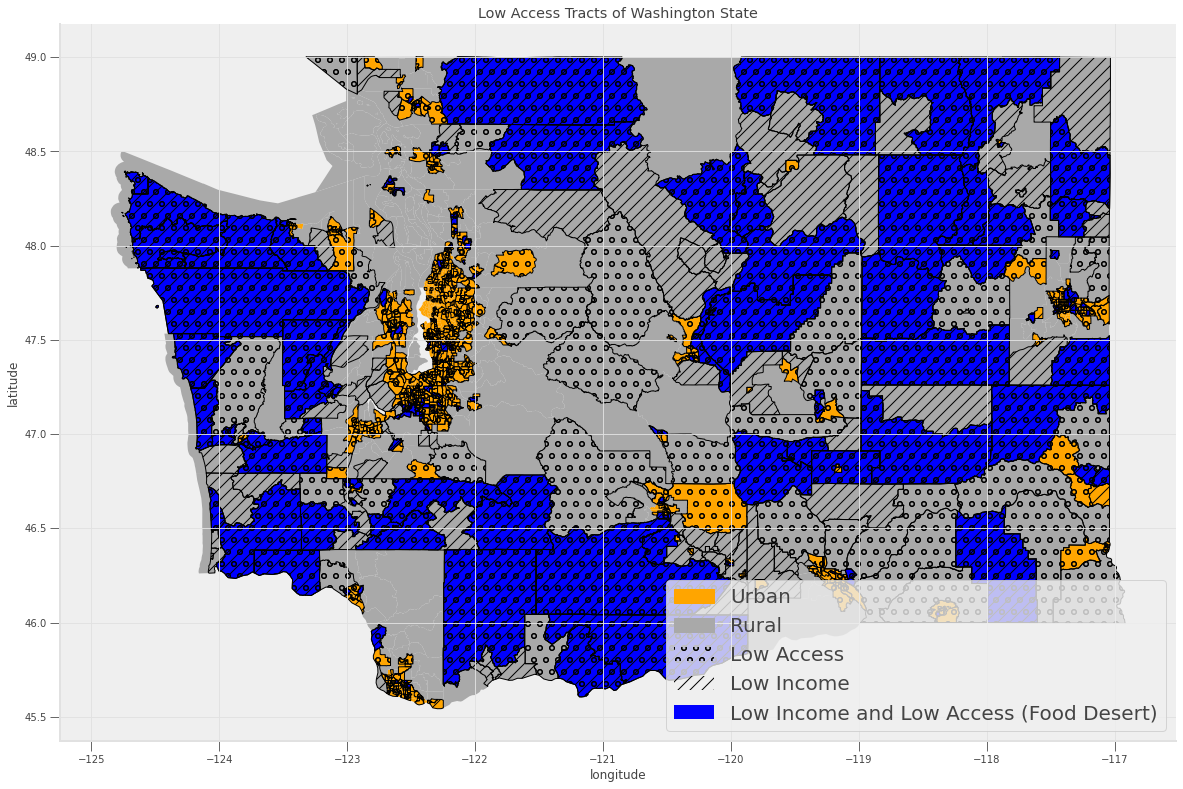

In [112]:
sub_la = sub['LA1and10'].value_counts()
print('Number of low access (1) census tracts vs non-low-income (0) census tracts in Washington State is\n', sub_la)
fig, ax = plt.subplots(figsize = (20,20))
lowaccess = dfa[dfa.LA1and10 == 1]

dfa[dfa.Urban == 1].plot(ax=ax, color='orange')
dfa[dfa.Urban == 0].plot(ax=ax, color='#a9a9a9')
dfa[dfa.LILATracts_1And10 == 1].plot(ax=ax, color='blue')

lowaccess.plot(ax=ax, facecolor='none', hatch="o", edgecolor= 'k')
lowincome.plot(ax=ax, facecolor='none', hatch="//", edgecolor= 'k')

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('Low Access Tracts of Washington State')

LegendElement = [
            patches.Patch(color='orange', label='Urban'),
            patches.Patch(color='#a9a9a9', label='Rural'),
            patches.Patch(facecolor='none', hatch="o", label='Low Access'),
            patches.Patch(facecolor='none', hatch="//", label='Low Income'),
            patches.Patch(facecolor='blue', label='Low Income and Low Access (Food Desert)')
                ]
ax.legend(handles = LegendElement, loc='lower right', fontsize = 20)

The mean and median of the low access (1) and non low access (0) census tracts:
         MedianFamilyIncome         
                       mean   median
LA1and10                            
0              70800.357995  66252.5
1              79506.183144  74442.0
The mean and median of the median family income of food desert (LILA) (1) and non food desert (non-LILA) (0) census tracts:
                  MedianFamilyIncome       
                                mean median
LILATracts_1And10                          
0                       77858.684953  74239
1                       50493.480447  51406
The mean and median of the median family income of low access urban (1) and non low access rural (0) census tracts:
      MedianFamilyIncome         
                    mean   median
Urban                            
0           56546.302632  56125.5
1           82731.600739  78100.0
The mean and median of the median family income of LILA urban (1) and LILA rural (0) census tracts:
     

<AxesSubplot:title={'center':'Average Median Income of LILA Urban VS LILA Rural Tracts'}, xlabel='Urban'>

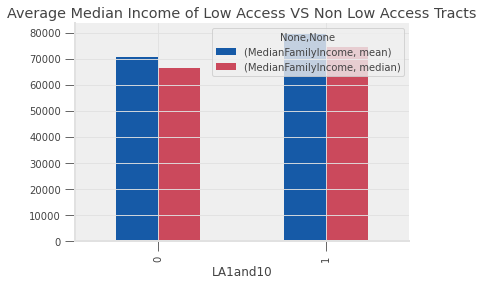

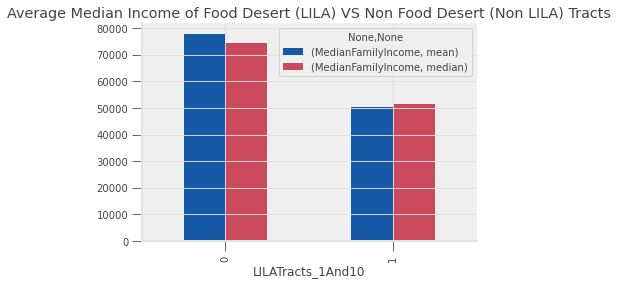

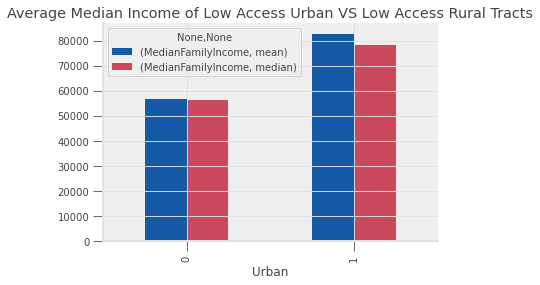

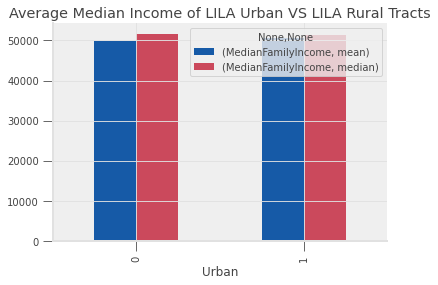

In [114]:
sub_income_la = sub.groupby(['LA1and10']).agg({'MedianFamilyIncome': ['mean', 'median']})
print('The mean and median of the low access (1) and non low access (0) census tracts:')
print(sub_income_la)
sub_income_la.plot(kind = 'bar', title = 'Average Median Income of Low Access VS Non Low Access Tracts')

sub_income_lila = sub.groupby(['LILATracts_1And10']).agg({'MedianFamilyIncome': ['mean', 'median']})
print('The mean and median of the median family income of food desert (LILA) (1) and non food desert (non-LILA) (0) census tracts:')
print(sub_income_lila)
sub_income_lila.plot(kind = 'bar', title = 'Average Median Income of Food Desert (LILA) VS Non Food Desert (Non LILA) Tracts')

sub_la_income_urban = sub[sub.LA1and10 == 1].groupby(['Urban']).agg({'MedianFamilyIncome': ['mean', 'median']})
print('The mean and median of the median family income of low access urban (1) and non low access rural (0) census tracts:')
print(sub_la_income_urban)
sub_la_income_urban.plot(kind = 'bar', title = 'Average Median Income of Low Access Urban VS Low Access Rural Tracts')

sub_lila_income_urban = sub[sub.LILATracts_1And10 == 1].groupby(['Urban']).agg({'MedianFamilyIncome': ['mean', 'median']})
print('The mean and median of the median family income of LILA urban (1) and LILA rural (0) census tracts:')
print(sub_lila_income_urban)
sub_lila_income_urban.plot(kind = 'bar', title = 'Average Median Income of LILA Urban VS LILA Rural Tracts')

POP2010
                       sum
LILATracts_1And10         
0                  5894452
1                   830088

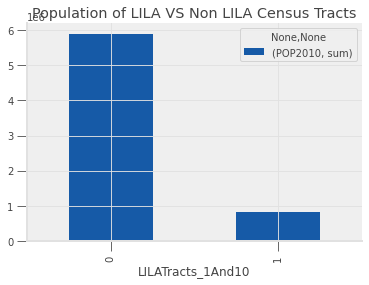

In [111]:
sub_pop_lila = sub.groupby(['LILATracts_1And10']).agg({'POP2010': ['sum']})
sub_pop_lila.plot(kind="bar", title = 'Population of LILA VS Non LILA Census Tracts')
sub_pop_lila

### Vehicle Ownership ###

Text(0.5, 1.0, 'Rates of households that do not own a vehicle in Washington')

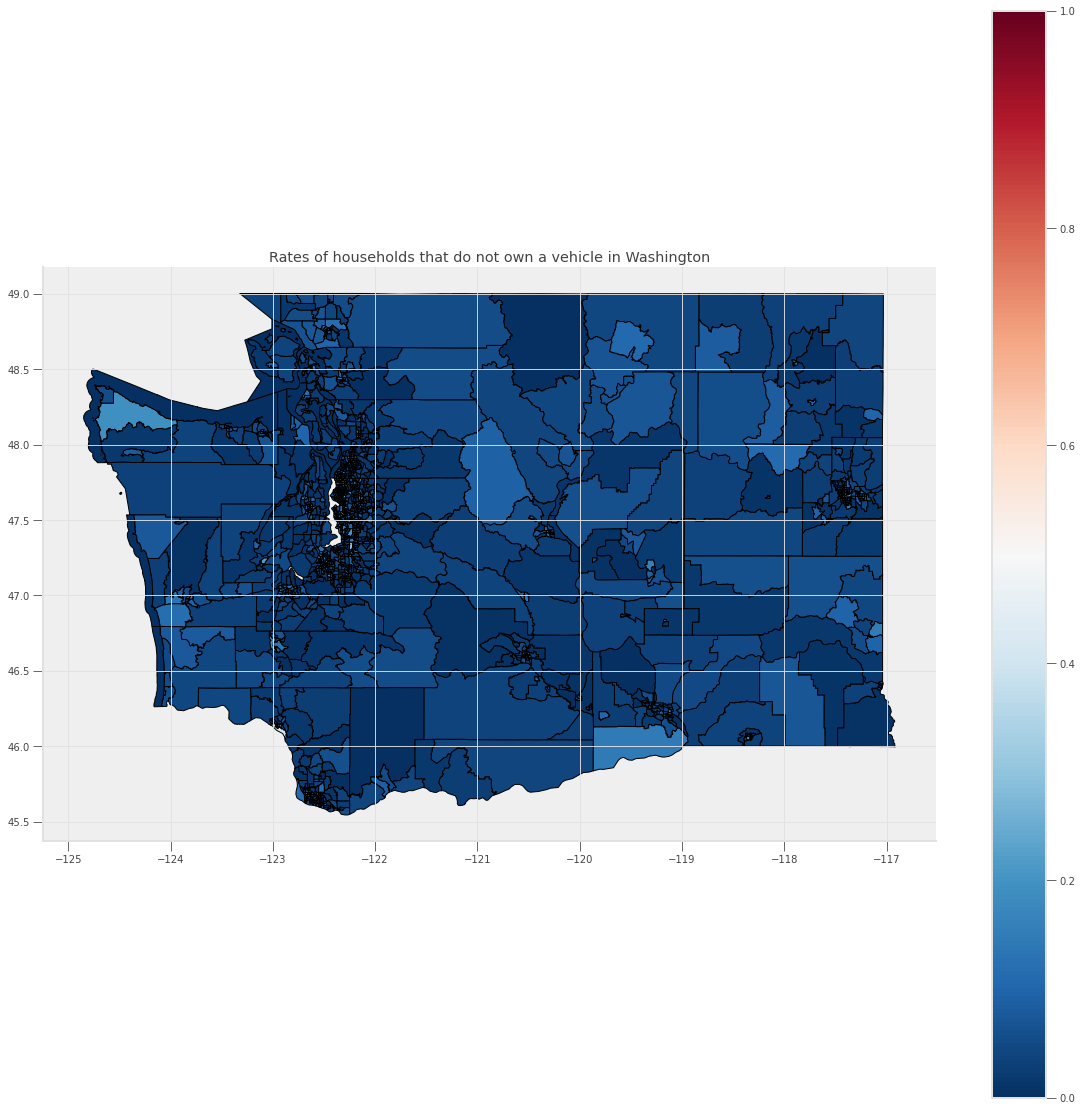

In [79]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='NoVehicleRate', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Rates of households that do not own a vehicle in Washington')

### Demographics ###

Here, we consider the share of certain demographics in the population of each of the census tracts:

Text(0.5, 1.0, 'Share of Black Population in Washington')

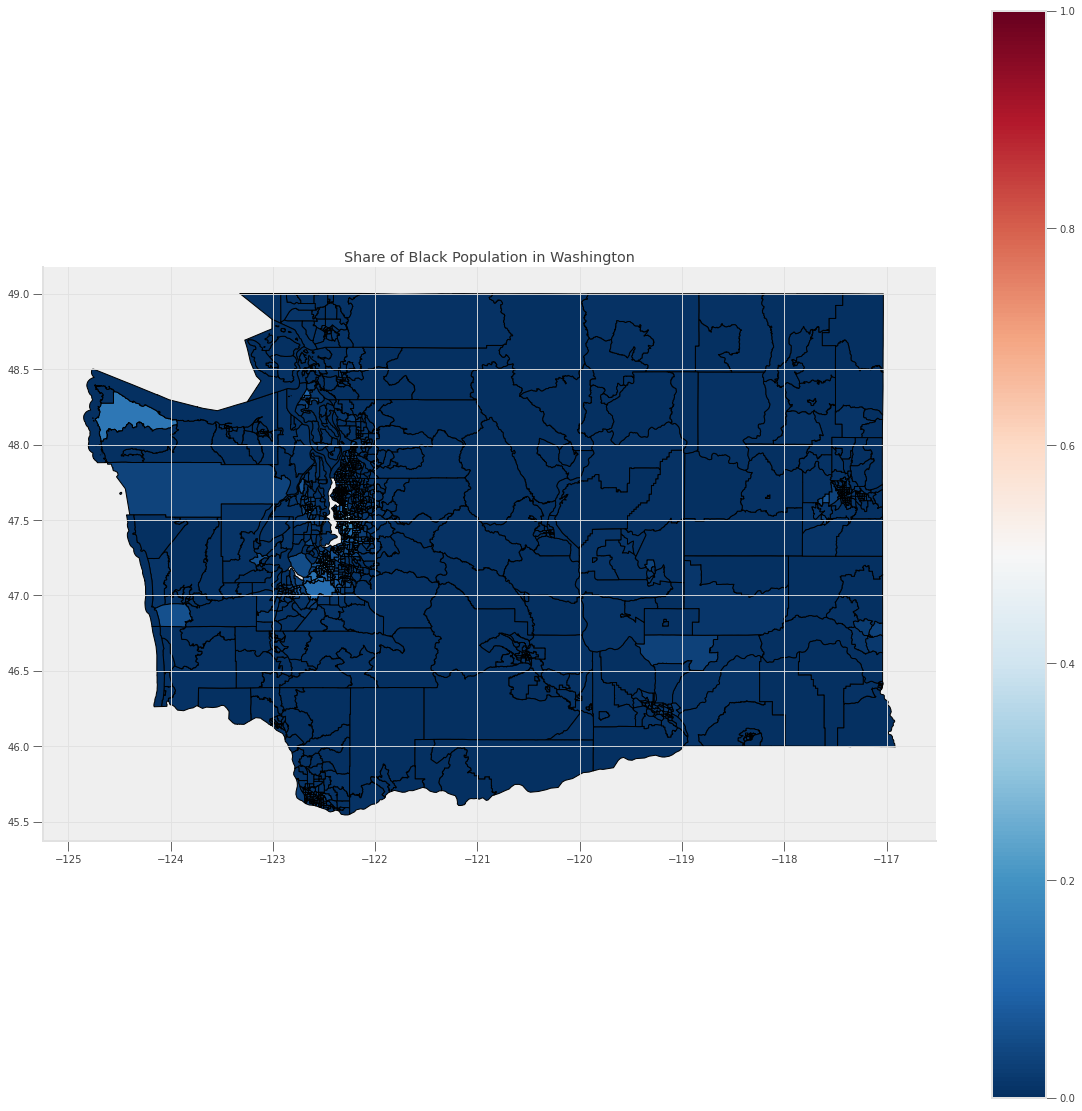

In [80]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='shareBlack', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Share of Black Population in Washington')

Text(0.5, 1.0, 'Share of White Population in Washington')

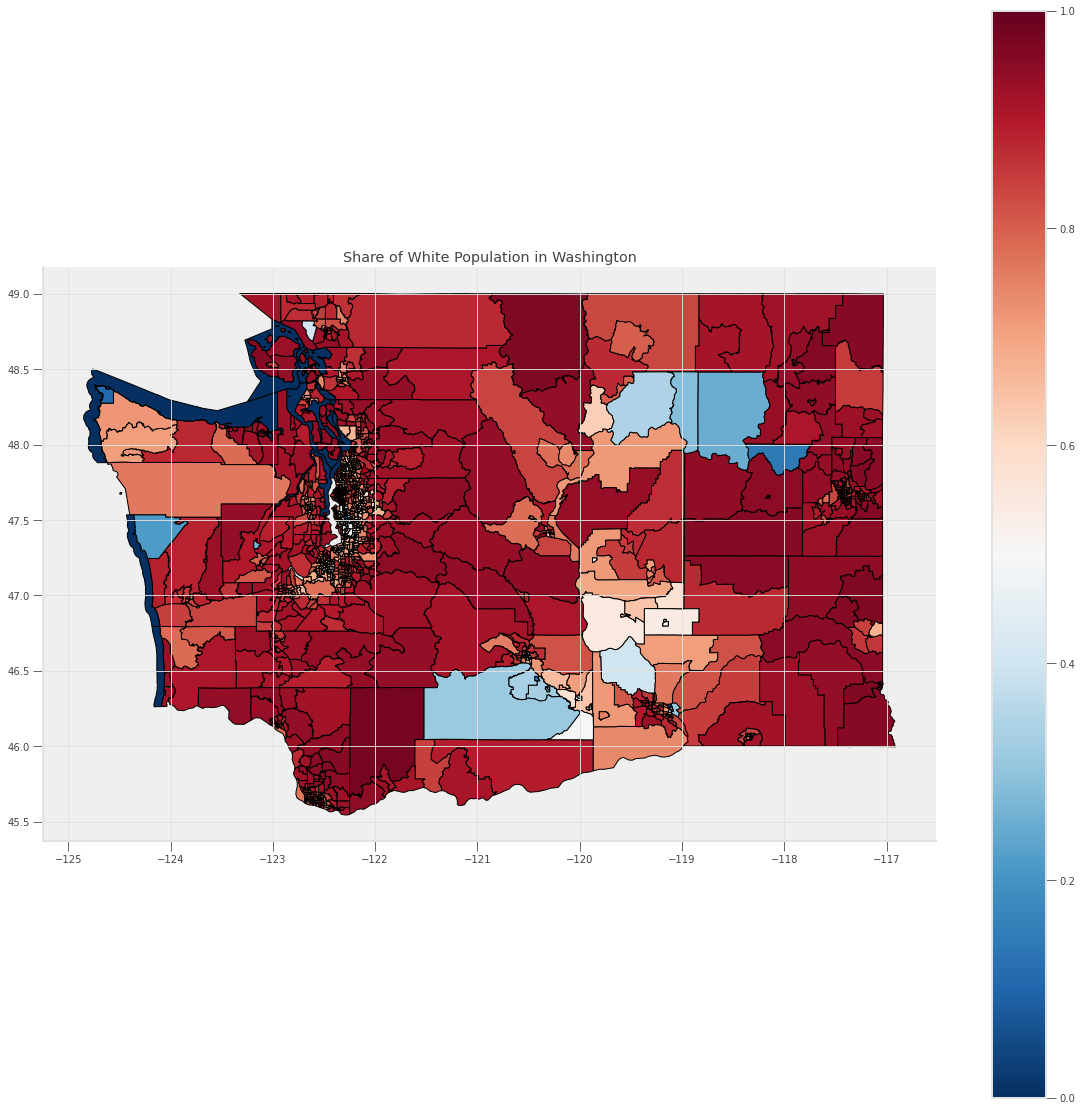

In [81]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='shareWhite', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Share of White Population in Washington')

Text(0.5, 1.0, 'Share of Asian Population in Washington')

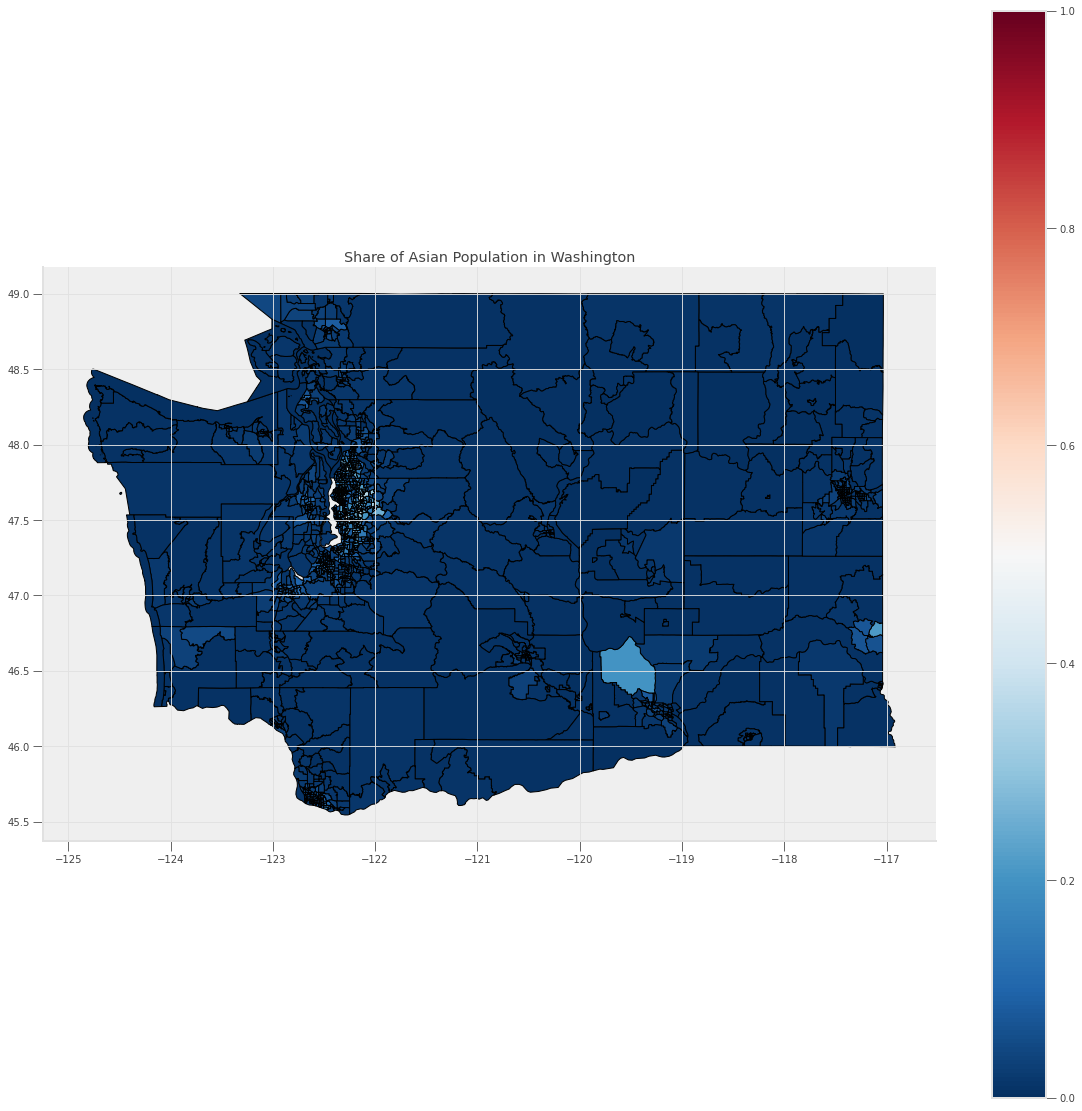

In [82]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='shareAsian', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Share of Asian Population in Washington')

Text(0.5, 1.0, 'Share of Native Hawaiian and Other Pacific Islander Population in Washington')

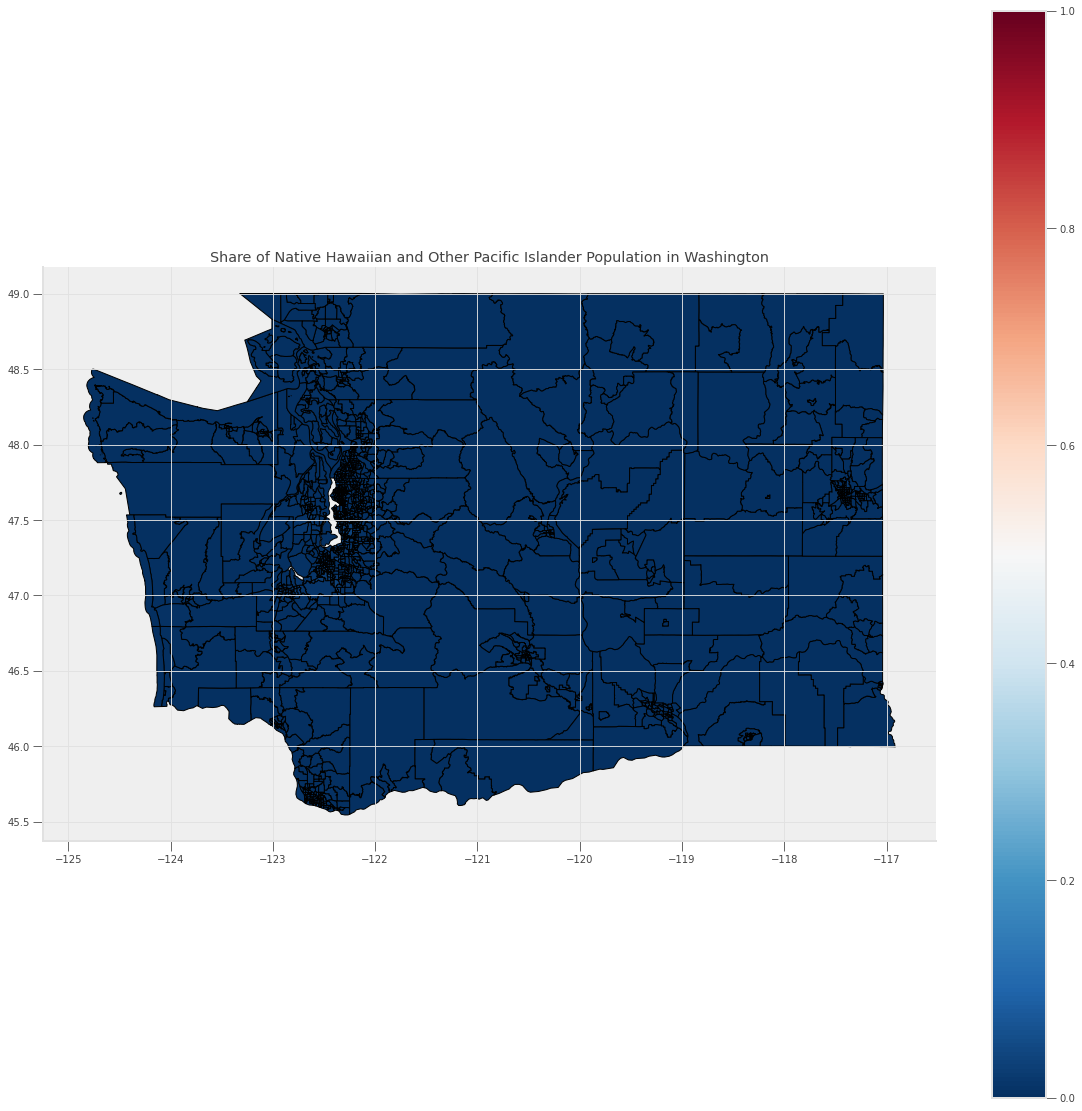

In [83]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='shareNHOPI', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Share of Native Hawaiian and Other Pacific Islander Population in Washington')

Text(0.5, 1.0, 'Share of Hispanic Population in Washington')

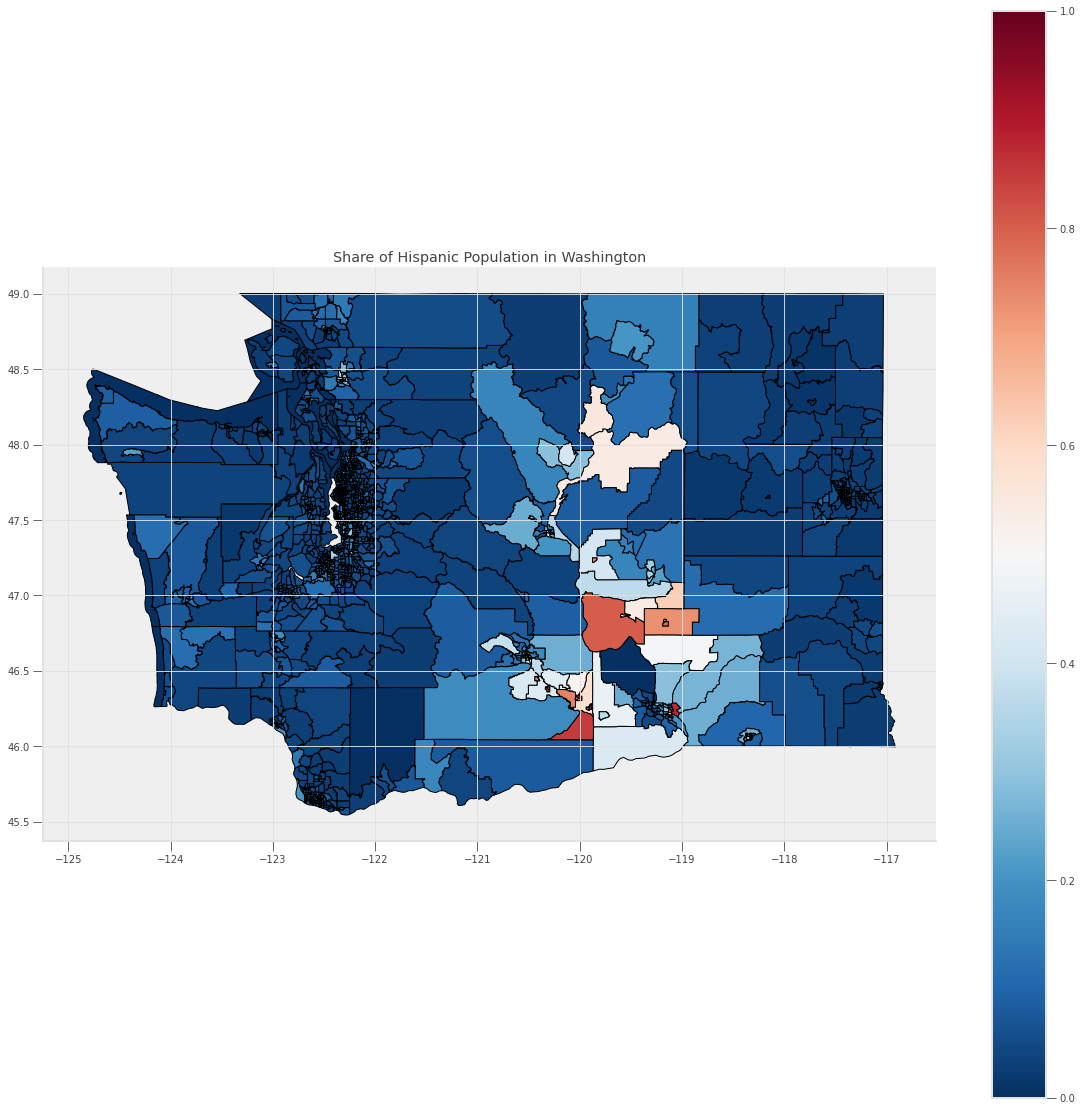

In [84]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='shareHispanic', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Share of Hispanic Population in Washington')

Text(0.5, 1.0, 'Share of American Indian and Native Alaskan Population in Washington')

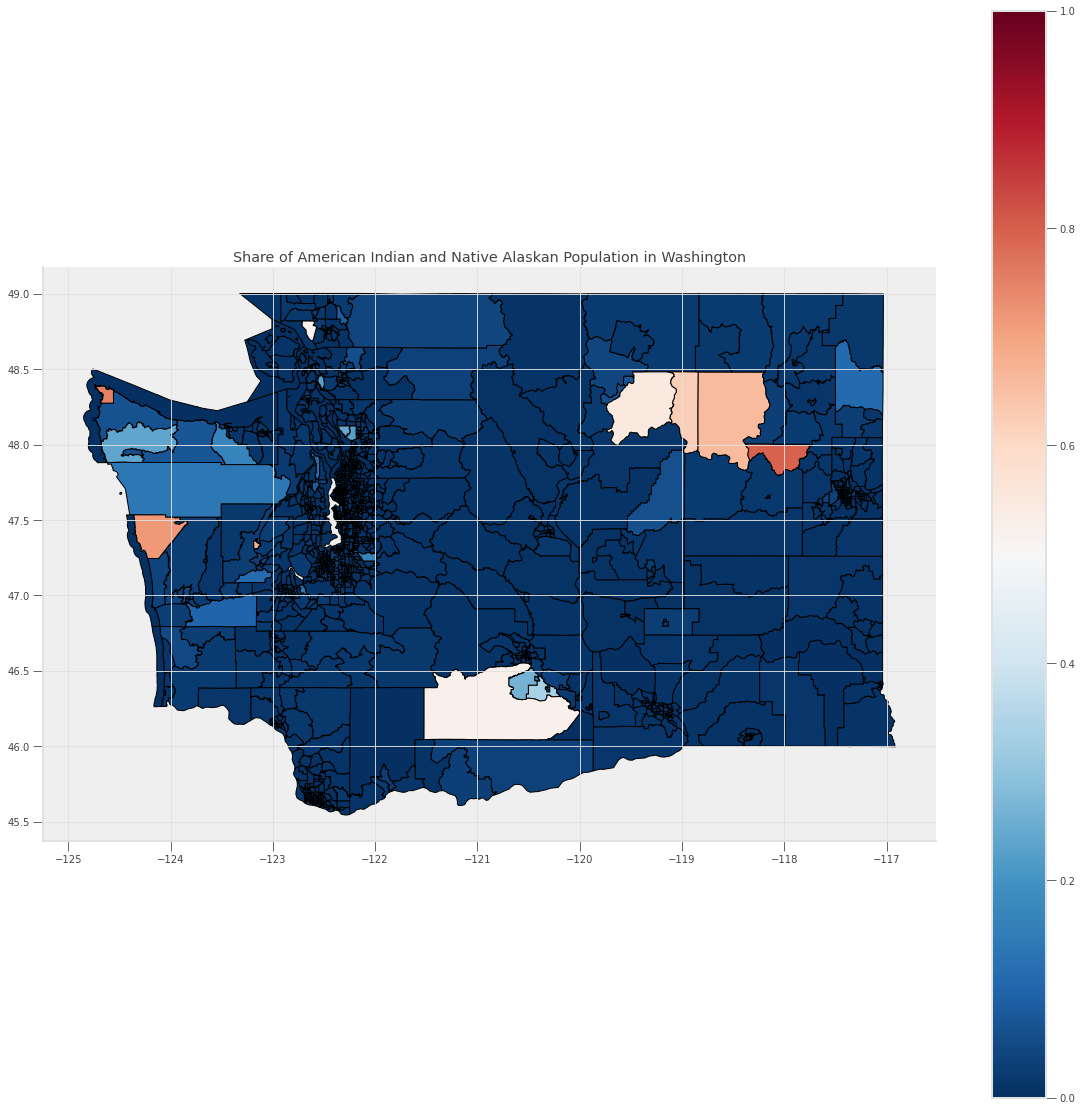

In [85]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='shareAIAN', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Share of American Indian and Native Alaskan Population in Washington')

Text(0.5, 1.0, 'Share of Children 17 Years Old Or Under Population in Washington')

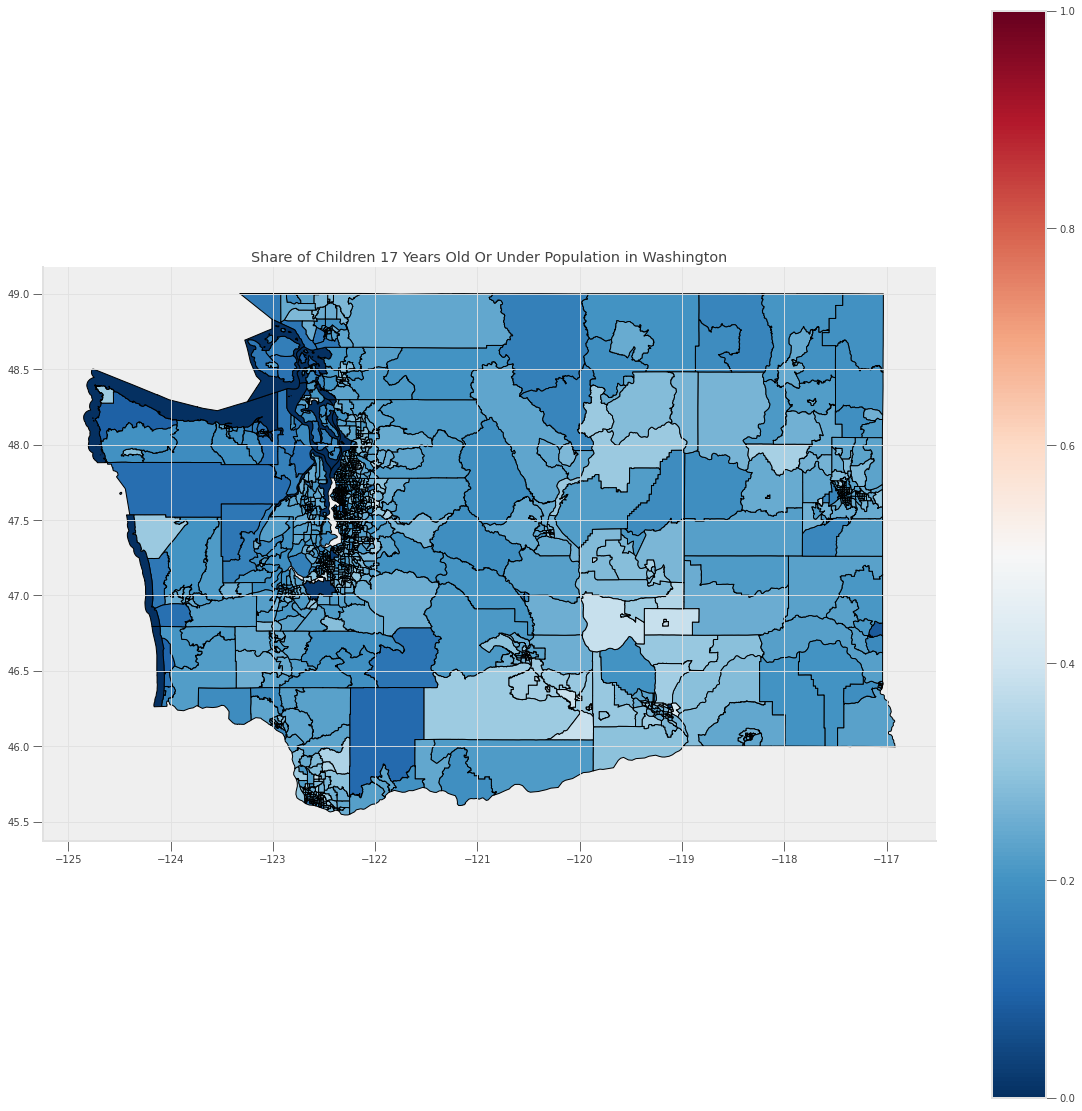

In [87]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='shareKids', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Share of Children 17 Years Old Or Under Population in Washington')

Text(0.5, 1.0, 'Share of Seniors 65 Years Old Or Above Population in Washington')

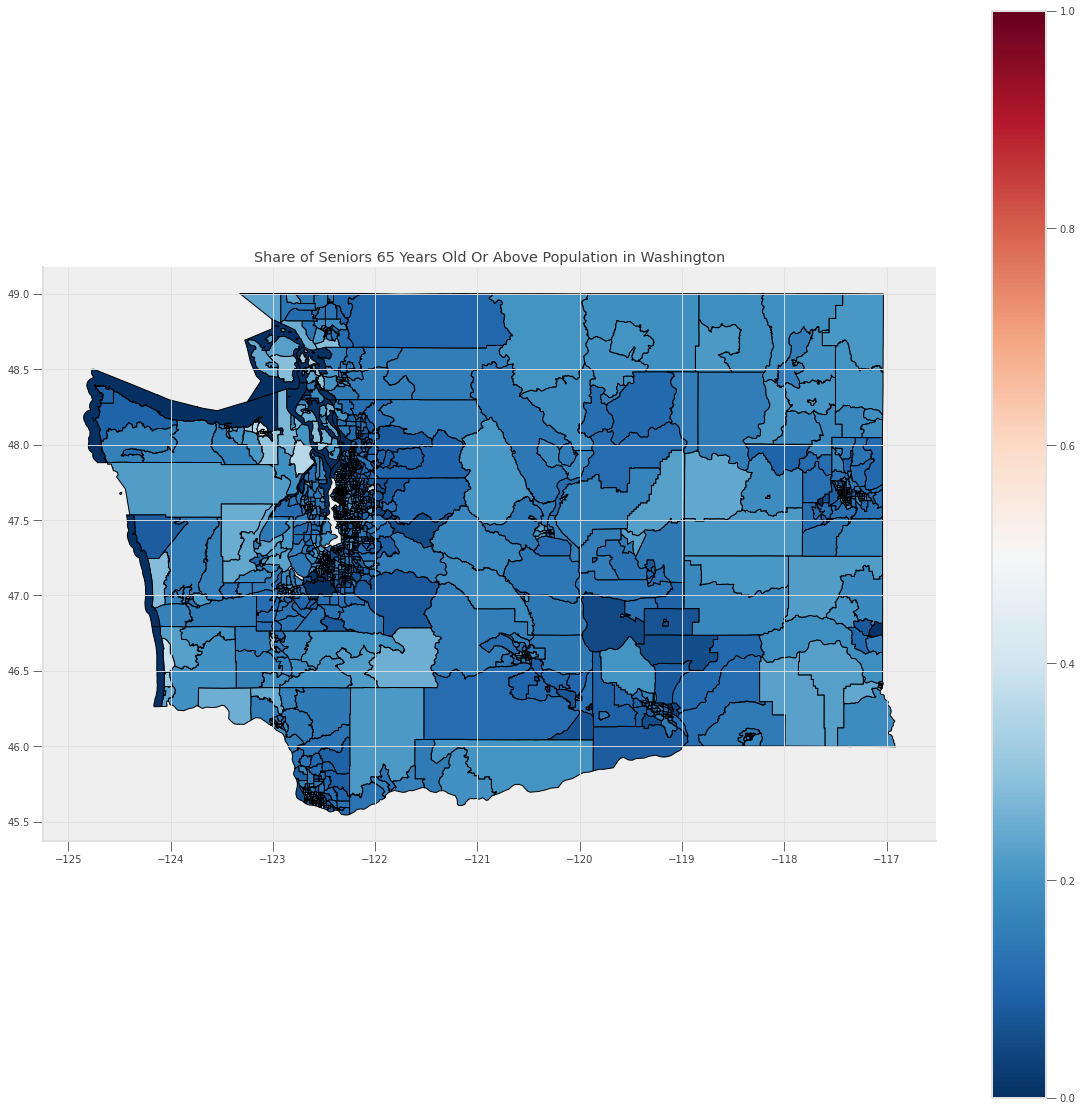

In [88]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='shareSeniors', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Share of Seniors 65 Years Old Or Above Population in Washington')

Text(0.5, 1.0, 'Share of SNAP beneficiaries Population in Washington')

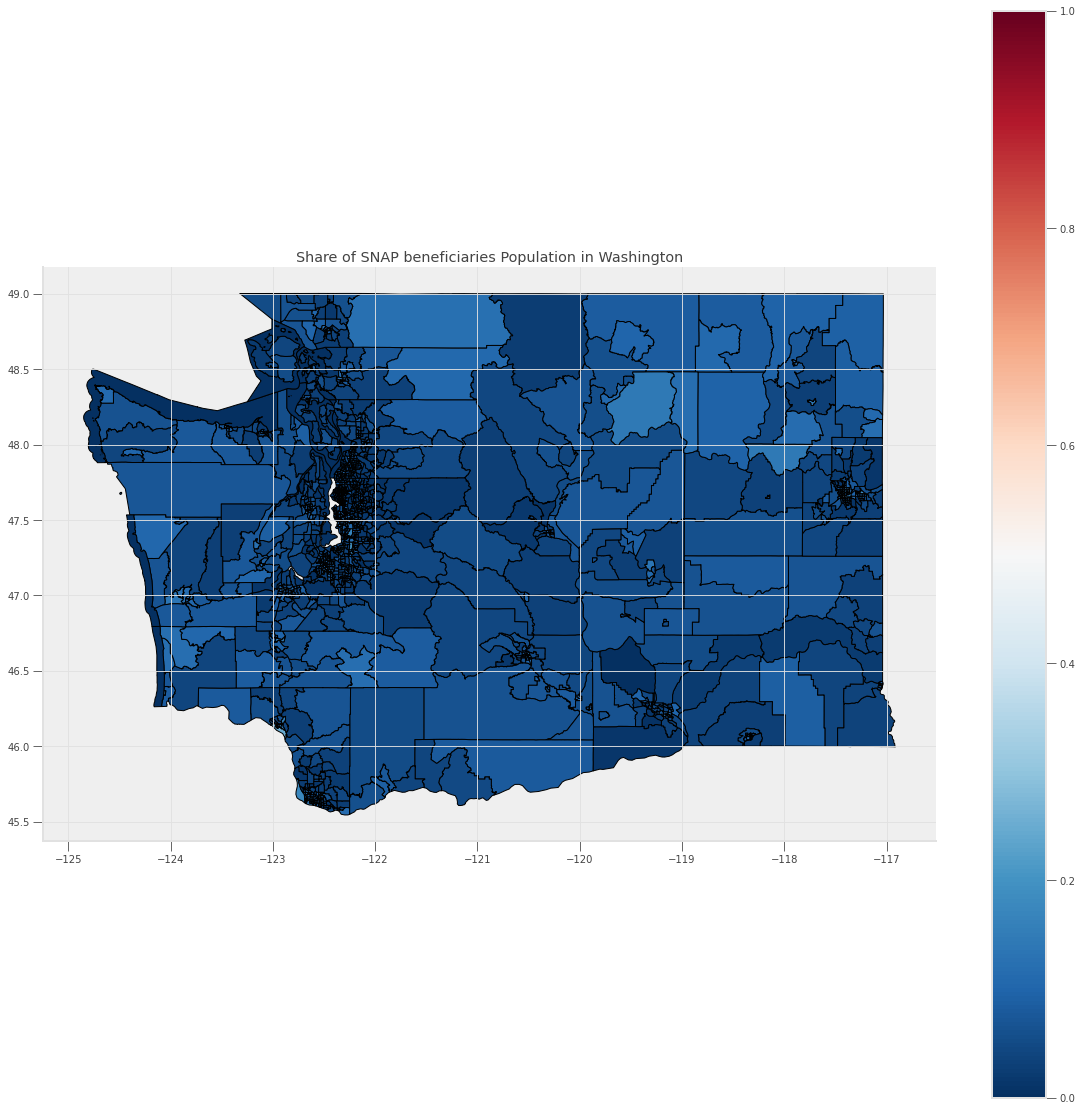

In [89]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='shareSNAP', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Share of SNAP beneficiaries Population in Washington')

Text(0.5, 1.0, 'Share of Low Income Population in Washington')

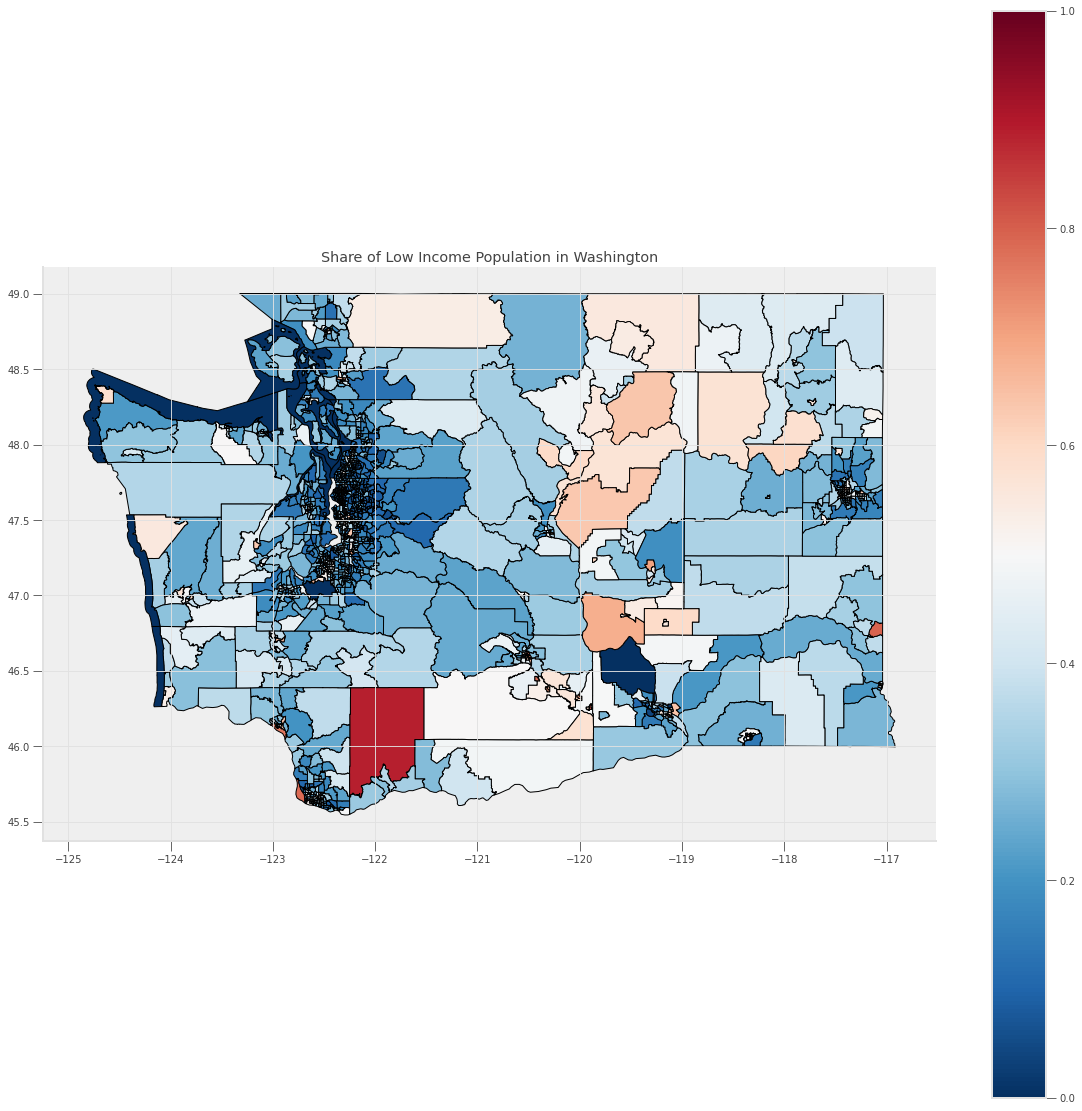

In [90]:
fig, ax = plt.subplots(figsize = (20,20))

dfa.plot(
    ax=ax, edgecolor='black', column='shareLOWI', legend=True, cmap='RdBu_r',
    vmin=0, vmax=1
)
ax.set_title('Share of Low Income Population in Washington')

It is clear that Washington State is a majority white and with a relatively low population of low income individuals.

# Prediction #

## Logistic Regression ##

We first tried to fit the data with a logistic regression model to see if the features play an important role in determining whether a census tract is said to be a low access.

In [95]:
vari = ['MedianFamilyIncome','shareBlack','shareWhite','shareAsian','shareNHOPI','shareHispanic','shareAIAN','shareMulti','shareKids','shareSeniors',
        'shareSNAP','shareLOWI','NoVehicleRate']
X = sub.loc[:, sub.columns.isin(vari)]
y = sub.loc[:, sub.columns =='LILATracts_1And10']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

logistic_model = linear_model.LogisticRegression(solver="lbfgs")
logistic_model.fit(X_train, y_train)

train_acc = logistic_model.score(X_train, y_train)
test_acc = logistic_model.score(X_test, y_test)

train_acc, test_acc

(0.8791748526522594, 0.8398169336384439)

It seems that we have run into an overfitting problem since the accuracy for the training data is higher than that of the testing data. We can use the p-value of the logit model to eliminate some unneccessary variables (eliminate those with p-value > 0.05).

In [96]:
result = logistic_model.fit(X_train, y_train)
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.278173
         Iterations 8
                          Results: Logit
Model:               Logit             Pseudo R-squared: 0.254     
Dependent Variable:  LILATracts_1And10 AIC:              835.4842  
Date:                2021-04-30 06:31  BIC:              904.1601  
No. Observations:    1455              Log-Likelihood:   -404.74   
Df Model:            12                LL-Null:          -542.58   
Df Residuals:        1442              LLR p-value:      5.9067e-52
Converged:           1.0000            Scale:            1.0000    
No. Iterations:      8.0000                                        
-------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
-------------------------------------------------------------------
MedianFamilyIncome -0.0001   0.0000 -6.7980 0.0000  -0.0001 -0.0000
shareBlack          2.9126   2.7818  1.04

In [97]:
new_vari = ['MedianFamilyIncome','shareNHOPI','shareLOWI','NoVehicleRate']
X = sub.loc[:, sub.columns.isin(new_vari)]
y = sub.loc[:, sub.columns =='LILATracts_1And10']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

logistic_model = linear_model.LogisticRegression(solver="lbfgs")
logistic_model.fit(X_train, y_train)

train_acc = logistic_model.score(X_train, y_train)
test_acc = logistic_model.score(X_test, y_test)

train_acc, test_acc

(0.8781925343811395, 0.8741418764302059)

After prunning the variables, it looks like our accurary for training and testing data have improved.

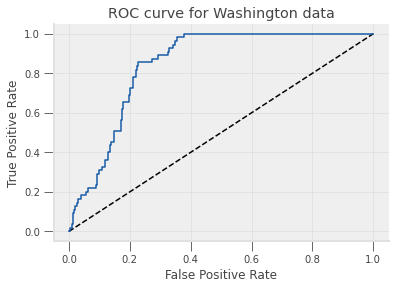

In [99]:
def plot_roc(mod, X, y, s):
    predicted_probs = mod.predict_proba(X_test)

    # keep the second column, for label=1
    predicted_prob1 = predicted_probs[:, 1]

    fpr, tpr, _ = metrics.roc_curve(y_test, predicted_prob1)

    # Plot ROC curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(s)
plot_roc(logistic_model, X_test, y_test, "ROC curve for Washington data")

In [100]:
predicted_prob1 = logistic_model.predict_proba(X)[:, 1]
auc = metrics.roc_auc_score(y, predicted_prob1)
print(f"Initial AUC value is {auc:.4f}")

Initial AUC value is 0.8241


Now, let's see if our results for Washington State matches that of the entire country

In [101]:
X = df_all.loc[:, df_all.columns.isin(vari)]
y = df_all.loc[:, df_all.columns =='LILATracts_1And10']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

logistic_model_all = linear_model.LogisticRegression(solver="lbfgs")
logistic_model_all.fit(X_train, y_train)

train_acc = logistic_model_all.score(X_train, y_train)
test_acc = logistic_model_all.score(X_test, y_test)

train_acc, test_acc

(0.872068857344522, 0.8711344922232388)

There does not seem to be any overfitting; however. let's try to see if we can simplify the model. Again, we can use the p-value of the logit model to eliminate some unneccessary variables (eliminate those with p-value > 0.05).

In [102]:
logit_model_all=sm.Logit(y,X)
result2=logit_model_all.fit()
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.309923
         Iterations 8
                          Results: Logit
Model:               Logit             Pseudo R-squared: 0.185     
Dependent Variable:  LILATracts_1And10 AIC:              45190.4574
Date:                2021-04-30 06:33  BIC:              45310.0100
No. Observations:    72864             Log-Likelihood:   -22582.   
Df Model:            12                LL-Null:          -27718.   
Df Residuals:        72851             LLR p-value:      0.0000    
Converged:           1.0000            Scale:            1.0000    
No. Iterations:      8.0000                                        
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
MedianFamilyIncome -0.0000   0.0000 -41.5747 0.0000 -0.0000 -0.0000
shareBlack          0.1915   0.0997   1.9

In [106]:
new_vari_all = ['MedianFamilyIncome','shareWhite','shareAsian','shareNHOPI','shareHispanic','shareAIAN','shareMulti','shareSeniors',
        'shareSNAP','shareLOWI','NoVehicleRate']
X = df_all.loc[:, df_all.columns.isin(new_vari_all)]
y = df_all.loc[:, df_all.columns =='LILATracts_1And10']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

logistic_model_all = linear_model.LogisticRegression(solver="lbfgs")
logistic_model_all.fit(X_train, y_train)

train_acc = logistic_model_all.score(X_train, y_train)
test_acc = logistic_model_all.score(X_test, y_test)

train_acc, test_acc

(0.8731275978354639, 0.8719121683440073)

It seems that the accuracy has not improved despite prunning; however, we still prefer a simplier model.

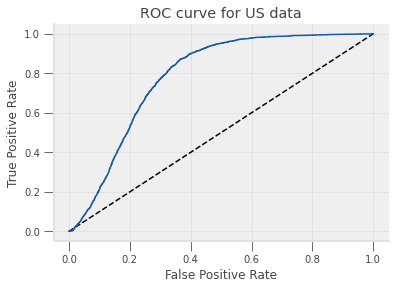

In [108]:
plot_roc(logistic_model_all, X_test, y_test, "ROC curve for US data")

In [109]:
predicted_prob2 = logistic_model_all.predict_proba(X)[:, 1]
auc2 = metrics.roc_auc_score(y, predicted_prob2)
print(f"Initial AUC value is {auc2:.4f}")

Initial AUC value is 0.7813


# Analysis #

It seems that there are more features that affect the probability of being classified as a low income low access census tract (aka a food desert) when we look at the data for the entire country than when we only look at the data from Washington State. However, the simplier model that we fitted with the Washington data yields a better ROC curve and AUC score than the more complex one we fitted with the entire US data.

It seems that since Washington State is more white and non-low-income dominant than the entirety of the US, the number of features that affect the probability of a census tract in Washington being classified as a food desert is fewer than that for the US data. 

Overall, the features of median family income, share of low income population, rates of non-vehicle ownership and proportion of Native Hawaiian and Other Pacific Islander population play a role in determining whether a census tract is classified as a food desert or not.

# Appendix #
Below is the lookup table for the column names in the sub dataframe.

In [4]:
lookup = pd.read_excel(data, sheet_name = 'Variable Lookup')
match = ['CensusTract', 'County', 'Urban', 'POP2010', 'OHU2010', 'MedianFamilyIncome','LILATracts_1And10', 'LowIncomeTracts', 'LA1and10',  'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 
'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP']
lookup = lookup[lookup.Field.isin(match)]


In [33]:
lookup.reset_index()

index               Field  \
0       0         CensusTract   
1       2              County   
2       3               Urban   
3       4             POP2010   
4       5             OHU2010   
5       9   LILATracts_1And10   
6      14     LowIncomeTracts   
7      16  MedianFamilyIncome   
8      17            LA1and10   
9     135           TractLOWI   
10    136           TractKids   
11    137        TractSeniors   
12    138          TractWhite   
13    139          TractBlack   
14    140          TractAsian   
15    141          TractNHOPI   
16    142           TractAIAN   
17    143        TractOMultir   
18    144       TractHispanic   
19    145           TractHUNV   
20    146           TractSNAP   

                                             LongName  \
0                                        Census tract   
1                                              County   
2                                         Urban tract   
3                             Population, tract total   
4                                Housing units, total   
5   Low income and low access tract measured at 1 ...   
6                                    Low income tract   
7                          Tract median family income   
8   Low access tract at 1 mile for urban areas and...   
9                 Tract low-income population, number   
10                    Tract children age 0-17, number   
11                      Tract seniors age 65+, number   
12                     Tract White population, number   
13  Tract Black or African American population, nu...   
14                     Tract Asian population, number   
15  Tract Native Hawaiian and Other Pacific Island...   
16  Tract American Indian and Alaska Native popula...   
17       Tract Other/Multiple race population, number   
18        Tract Hispanic or Latino population, number   
19      Tract housing units without a vehicle, number   
20  Tract housing units receiving SNAP benefits, n...   

                                          Description  
0                                 Census tract number  
1                                         County name  
2                                Flag for urban tract  
3                   Population count from 2010 census  
4        Occupied housing unit count from 2010 census  
5   Flag for food desert when considering low acce...  
6                           Flag for low income tract  
7                          Tract median family income  
8   Flag for low access tract at 1 mile for urban ...  
9      Total count of low-income population in tract   
10         Total count of children age 0-17 in tract   
11           Total count of seniors age 65+ in tract   
12          Total count of White population in tract   
13  Total count of Black or African American popul...  
14          Total count of Asian population in tract   
15  Total count of Native Hawaiian and Other Pacif...  
16  Total count of American Indian and Alaska Nati...  
17  Total count of Other/Multiple race population ...  
18  Total count of Hispanic or Latino population i...  
19  Total count of housing units without a vehicle...  
20  Total count of housing units receiving SNAP be...